In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset loading

In [54]:
dataset = pd.read_csv('../Y3 - Sample data/Z2 - datasetprepclean.csv', index_col = 0,
                     )
print('dataset shape:', dataset.shape)
dataset.head()

dataset shape: (5401, 535)


,cut_length,num_closed_patterns,num_open_patterns,total_area,minimum_rectangle_area,minimum_rectangle_dim1,minimum_rectangle_dim2,convex_hull_area,no_hole_area,thickness,...,thick_12.0,thick_15.0,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group
COART,,,,,,,,,,,,,,,,,,,,,
L1600360,3178.489502,9,0,285678.093750,431798.46875,722.070984,598.000000,320484.593750,286893.718750,4.0,...,0,0,0,12.51,5.15,17.66,0.000010,0.000007,0.000011,3-5
L1600470,317.114502,1,0,3403.138184,3500.00000,140.000000,25.000000,3403.138184,3403.138184,10.0,...,0,0,0,0.25,0.92,1.17,0.000007,0.000007,0.000007,0
L1600600,3710.627930,1,0,522587.812500,522587.81250,1509.000000,346.313995,522587.812500,522587.812500,3.0,...,0,0,0,18.36,7.55,25.91,0.000012,0.000012,0.000012,1-2
L1600610,3232.627930,1,0,439818.781250,439818.78125,1270.000000,346.313995,439818.781250,439818.781250,3.0,...,0,0,0,9.18,4.77,13.95,0.000007,0.000007,0.000007,1-2
L1600620,2972.627930,1,0,394797.968750,394797.96875,1140.000000,346.313995,394797.968750,394797.968750,3.0,...,0,0,0,9.18,4.65,13.83,0.000008,0.000008,0.000008,1-2


In [55]:
#dataset.columns.values

In [56]:
for index, nancount in dataset.isnull().sum().iteritems():
    if nancount != 0:
        print(index, '-->', nancount)
else:
    print('Done !')
dataset.shape

benddxf_deformation_length_00 --> 262
benddxf_deformation_length_01 --> 123
benddxf_deformation_length_02 --> 19
benddxf_deformation_length_03 --> 6
benddxf_deformation_length_04 --> 1
benddxf_deformation_length_05 --> 1
temp --> 5326
Done !


(5401, 535)

In [57]:
#Cleaning of the remaining Nan

subset = [x for x in dataset.columns.values if x.startswith('bend_gr_')]

#dataset = dataset.fillna(0)
dataset = dataset.dropna(subset=subset)
dataset.shape

(5401, 535)

# cleaning to have at least min occurences

In [58]:
minocc = 50
todrop = []
df = dataset['thickness'].reset_index().groupby('thickness').count()
for index, occ in df.iterrows():
    if occ.COART <= minocc:
        todrop.append(index)

for thickness in todrop:
    dataset = dataset[dataset['thickness'] != thickness]
dataset.shape

(5358, 535)

# Dataset re-ordering and Splitting

The baseline will be defined with the 3 core factors:
- Thickness
- Area
- Number of bends

In [59]:
#Dataset definition
X = dataset[['thickness', 'minimum_rectangle_area', 'bend_count']]
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

limitedset = ['thickness', 'minimum_rectangle_area', 'bend_count']


# Target definition

In [61]:
target = 'VAMAT'
assert target in y.columns.values, 'The target must be in y dataset'

# Outlier tracking - VAMAT

In [62]:
toplimit = .97 #We drop the top 3%
botlimit = .02 #we drop the bottom 2%

In [63]:
#Surface cost calculation, quantile decomposition

#dataset['SURF_COST_CONVHULL'] = dataset['VAMAT'] / dataset['convex_hull_area']
dataset['SURF_COST_RECTANGLE'] = dataset['VAMAT'] / dataset['minimum_rectangle_area']
#dataset['SURF_COST_MPATTERN'] = dataset['VAMAT'] / dataset['no_hole_area']
#dataset['SURF_COST_TOTAREA'] = dataset['VAMAT'] / dataset['total_area']

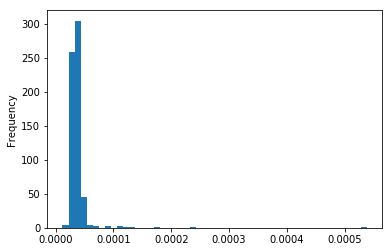

In [64]:
df = dataset[dataset['thickness'] == 5]
df['SURF_COST_RECTANGLE'].plot.hist(bins=50)
plt.show()

In [65]:
#quantile decomposition
df=dataset[['thickness', 'SURF_COST_RECTANGLE']].groupby('thickness').quantile([botlimit,toplimit])
df

SURF_COST_RECTANGLE
thickness                          
2.0       0.02             0.000011
          0.97             0.000028
3.0       0.02             0.000017
          0.97             0.000049
4.0       0.02             0.000020
          0.97             0.000054
5.0       0.02             0.000025
          0.97             0.000053
6.0       0.02             0.000029
          0.97             0.000079
8.0       0.02             0.000041
          0.97             0.000101
10.0      0.02             0.000048
          0.97             0.000132
12.0      0.02             0.000045
          0.97             0.000138
15.0      0.02             0.000059
          0.97             0.000154

In [66]:
# If vamat is target, cleaning
if target == 'VAMAT' or target == 'VALTOT':
    for (thickness, limit), value in df.iterrows():
        tresh = value.values[0]
        if limit == botlimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(dataset['thickness'] == thickness, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(5088, 536)

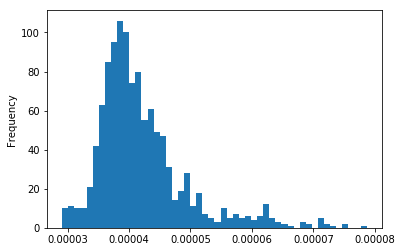

In [67]:
df = dataset[dataset['thickness'] == 6]
df['SURF_COST_RECTANGLE'].plot.hist(bins=50)
plt.show()

# Outlier tracking - VALAJOUT

In [68]:
toplimit = .95 #We drop the top 5%
botlimit = .02 #we drop the bottom 2%

In [69]:
#Cost per bend calculation

dataset['APPROX_BEND_COST'] = dataset['VALAJOUT'] / (dataset['bend_count']+1)

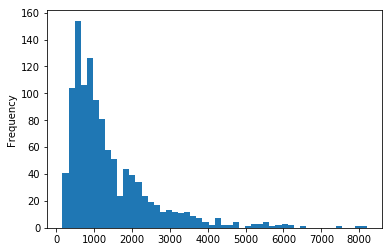

In [70]:
df = dataset[dataset['thickness'] == 6]
df[df.columns.values[0]].plot.hist(bins=50)
plt.show()

In [71]:
#quantile decomposition
df=dataset[['thickness', 'APPROX_BEND_COST', 'bend_count']].groupby(['thickness', 'bend_count']).quantile([botlimit,toplimit])
df

APPROX_BEND_COST
thickness bend_count                       
2.0       0          0.02          0.706400
                     0.95          6.994000
          1          0.02          0.523400
                     0.95          2.293750
          2          0.02          0.248533
                     0.95          2.147333
          3          0.02          0.624250
                     0.95          2.315000
          4          0.02          0.576240
                     0.95          2.126900
          5          0.02          0.258333
                     0.95          2.060000
          6          0.02          0.703314
                     0.95          1.496000
          7          0.02          0.698875
                     0.95          1.446875
          8          0.02          0.782978
                     0.95          2.421111
          9          0.02          0.639000
                     0.95          0.639000
          14         0.02          0.502000
                     0.95          0.502000
3.0       0          0.02          0.217600
                     0.95          6.584000
          1          0.02          0.444600
                     0.95          1.468750
          2          0.02          0.406800
                     0.95          1.902333
          3          0.02          0.365650
                     0.95          2.394875
...                                     ...
10.0      0          0.02          0.593800
                     0.95          8.698500
          1          0.02          0.930000
                     0.95          4.195000
          2          0.02          0.523067
                     0.95          4.009667
          3          0.02          0.991400
                     0.95          3.754500
          4          0.02          1.173360
                     0.95          3.514800
          5          0.02          1.855000
                     0.95          1.855000
12.0      0          0.02          0.570000
                     0.95          6.842500
          1          0.02          0.233800
                     0.95          2.344000
          2          0.02          0.433067
                     0.95          4.183333
          3          0.02          0.621250
                     0.95          1.167625
          4          0.02          1.814120
                     0.95          1.819700
15.0      0          0.02          0.812600
                     0.95          9.275500
          1          0.02          1.100000
                     0.95          3.058500
          2          0.02          0.853333
                     0.95          7.126667
          3          0.02          0.870000
                     0.95          1.833750

[146 rows x 1 columns]

In [72]:
# If VALAJOUT is target, cleaning
if target == 'VALAJOUT' or target == 'VALTOT':
    for (thickness, bend_count, limit), value in df.iterrows():
        tresh = value.values[0]
        mask1 = np.logical_and(dataset['thickness'] == thickness, dataset['bend_count'] == bend_count)
        if limit == botlimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] < tresh)
            dataset = dataset[np.logical_not(mask)]
        elif limit == toplimit:
            mask = np.logical_and(mask1, dataset[df.columns.values[0]] > tresh)
            dataset = dataset[np.logical_not(mask)]
        #print((thickness, limit), tresh)

dataset.shape

(5088, 537)

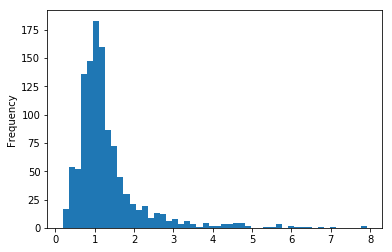

In [73]:
df = dataset[dataset['thickness'] == 6]
df['APPROX_BEND_COST'].plot.hist(bins=50)
plt.show()

# Target review

In [74]:
#Dataset definition
X = dataset
y = dataset[['VAMAT', 'VALAJOUT', 'VALTOT']]

In [75]:
y[[target]].describe()

,VAMAT
count,5088.000000
mean,6.495664
std,11.842723
min,0.110000
25%,0.880000
50%,2.500000
75%,7.010000
max,153.600000


In [76]:
# Dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0 ,stratify=dataset['bend_group'])
print(X_train.shape, X_test.shape)

(3561, 537) (1527, 537)


# Blocs creation

In [77]:
#Scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [78]:
# Metric
from sklearn.metrics import mean_squared_error

In [79]:
# Metric MAPE Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import make_scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
mape_scorer

make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [80]:
#regressions
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0, random_state=0, normalize=False, fit_intercept=False)

from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=False, fit_intercept=False)

from sklearn.linear_model import LinearRegression
linreg = LinearRegression(normalize=False, fit_intercept=False)

In [81]:
#Other tools
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# No standardisation

In [126]:
parameters = {'alpha':np.logspace(-3,-3,11),
              'l1_ratio':np.linspace(0.001,1,11)
             }
regnostd = GridSearchCV(enet, parameters, cv=5, n_jobs=-2, scoring='neg_mean_squared_error')

In [127]:
regnostd.fit(X_train[limitedset], y_train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=0, copy_X=True, fit_intercept=False, l1_ratio=1,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-2,
       param_grid={'alpha': array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001]), 'l1_ratio': array([0.001 , 0.1009, 0.2008, 0.3007, 0.4006, 0.5005, 0.6004, 0.7003,
       0.8002, 0.9001, 1.    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [128]:
regnostd.estimator.l1_ratio

1

In [84]:
regnostd.best_params_

{'alpha': 0.015848931924611134, 'l1_ratio': 0.01}

In [85]:
regnostd.score(X_train[limitedset], y_train[target])

-36.42500120164653

In [86]:
regnostd.score(X_test[limitedset], y_test[target])

-30.98608853046048

In [87]:
mean_squared_error(y_test[target], regnostd.predict(X_test[limitedset]))

30.98608853046048

In [88]:
regnostd.best_estimator_.coef_

array([ 3.74171119e-01,  4.41949135e-05, -1.12406155e+00])

In [89]:
regnostd.predict(np.array([10.0, 123061.765625, 2]).reshape(1,-1))

array([6.93229218])

In [90]:
(np.array([10.0, 123061.765625, 2]) * regnostd.best_estimator_.coef_).sum()

6.932292184188903

# VAMAT simplified

In [92]:
df = dataset.groupby('thickness')['SURF_COST_RECTANGLE']
df.agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
thickness,,,,,
2.0,0.000017,0.000003,0.000012,0.000027,0.000015
3.0,0.000023,0.000006,0.000017,0.000049,0.000021
4.0,0.000028,0.000006,0.000020,0.000053,0.000027
5.0,0.000035,0.000005,0.000025,0.000053,0.000033
6.0,0.000042,0.000007,0.000029,0.000079,0.000040
8.0,0.000057,0.000009,0.000041,0.000100,0.000055
10.0,0.000073,0.000014,0.000048,0.000132,0.000069
12.0,0.000084,0.000017,0.000046,0.000131,0.000081
15.0,0.000101,0.000021,0.000062,0.000152,0.000100


In [108]:
surfcost = df.agg('mean').to_dict()
surfcost

{2.0: 1.6647433272606047e-05,
 3.0: 2.293063273168112e-05,
 4.0: 2.841553356513595e-05,
 5.0: 3.4553861237483286e-05,
 6.0: 4.205112340780939e-05,
 8.0: 5.666598451654835e-05,
 10.0: 7.267847331839946e-05,
 12.0: 8.383169256994243e-05,
 15.0: 0.00010141223060481343}

In [109]:
def vamatfeat(entry):
    return entry['minimum_rectangle_area'] * surfcost.get(entry['thickness'],0)

dataset['VAMAT_pred'] = dataset.apply(vamatfeat, axis=1)
dataset[['VAMAT', 'VAMAT_prod']].head()

,VAMAT,VAMAT_prod
COART,,
L1600360,12.51,12.269784
L1600470,0.25,0.254375
L1600600,18.36,11.983269
L1600610,9.18,10.085323
L1600620,9.18,9.052967


/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


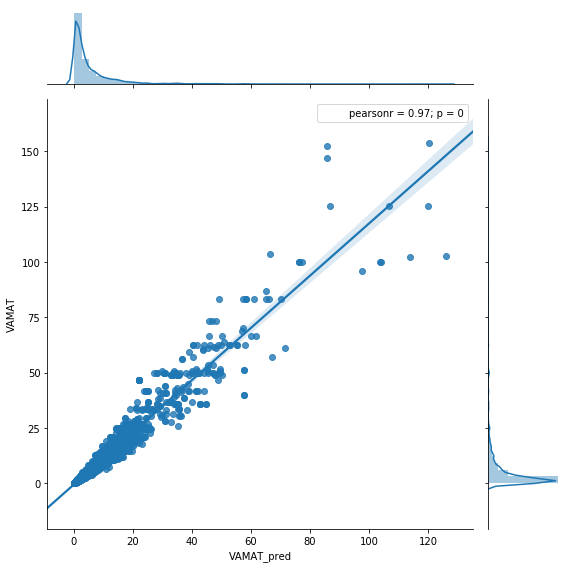

In [110]:
sns.jointplot(x='VAMAT_pred', y='VAMAT', data=dataset, kind='reg', size=8)

In [106]:
mean_squared_error(dataset['VAMAT'], dataset['VAMAT_pred'])

13.723230970841827

In [107]:
mean_absolute_percentage_error(dataset['VAMAT'], dataset['VAMAT_pred'])

11.617992006087446

# Per thickness

In [38]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_X_y

In [136]:
class Regthick(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.thickness = []
    
    def fit(self, X, y):
        #X, y = check_X_y(X, y)
        self.thickness = X['thickness'].unique()
        parameters = {'alpha':np.logspace(-3,3,5),
                      'l1_ratio':np.linspace(0.01,1,5)
                        }
        for thickness in self.thickness:
            setattr(self, 'reg{:02d}'.format(int(thickness)),
                    GridSearchCV(ElasticNet(alpha=0, l1_ratio=1, random_state=0, normalize=False, fit_intercept=False),
                                 parameters, cv=3, n_jobs=-2, scoring='neg_mean_squared_error'))
            
            mask = X['thickness']==thickness
            #print(X.columns.values)
            df = X[mask]
            labels = y[mask]
            getattr(self, 'reg{:02d}'.format(int(thickness))).fit(df[['minimum_rectangle_area', 'bend_count']], labels)
    
    def predict(self, X, y=None):
        thickness = X[0]
        df = np.array(X[1:]).reshape(1, -1)
        return getattr(self, 'reg{:02d}'.format(int(thickness))).predict(df)
    
    def get_l1_ratio(self):
        toreturn = []
        for th in self.thickness:
            toreturn.append((th, getattr(self, 'reg{:02d}'.format(int(thickness))).estimator.l1_ratio))
        return toreturn
    
    def get_alpha(self):
        toreturn = []
        for th in self.thickness:
            toreturn.append((th, getattr(self, 'reg{:02d}'.format(int(thickness))).estimator.alpha))
        return toreturn
        
    def get_th_coefs(self):
        toreturn = []
        for th in self.thickness:
            temp = []
            estim = getattr(self, 'reg{:02d}'.format(int(th)))
            coeffs = estim.best_estimator_.coef_.copy()
            temp.append(th)
            temp.extend(coeffs.tolist())
            toreturn.append(temp)
        return np.array(toreturn)
    


In [137]:
regthick = Regthick()
regthick.fit(X_train[limitedset], y_train[target])

In [138]:
regthick.get_l1_ratio()

[(12.0, 1),
 (10.0, 1),
 (8.0, 1),
 (5.0, 1),
 (4.0, 1),
 (3.0, 1),
 (2.0, 1),
 (6.0, 1),
 (15.0, 1)]

In [139]:
regthick.get_alpha()

[(12.0, 0),
 (10.0, 0),
 (8.0, 0),
 (5.0, 0),
 (4.0, 0),
 (3.0, 0),
 (2.0, 0),
 (6.0, 0),
 (15.0, 0)]

In [140]:
#regthick.reg10.predict(np.array([10.0, 123061.765625, 2]).reshape(1,-1))
regthick.predict([10.0, 123061.765625, 2])

array([10.21559653])

In [141]:
np.dot(regthick.reg10.best_estimator_.coef_, [123061.765625, 2])

10.215596533554109

In [142]:
#1.26214574e-05 * 123061.765625 + 6.96330034e-01*2
regthick.get_th_coefs()

array([[ 1.20000000e+01,  9.23632333e-05, -1.44045191e-01],
       [ 1.00000000e+01,  8.58973281e-05, -1.77540165e-01],
       [ 8.00000000e+00,  6.38848880e-05, -1.64993088e-01],
       [ 5.00000000e+00,  3.53156182e-05,  0.00000000e+00],
       [ 4.00000000e+00,  3.63032276e-05, -4.06959070e-01],
       [ 3.00000000e+00,  3.14388324e-05, -4.27172106e-01],
       [ 2.00000000e+00,  1.89725136e-05, -5.43808729e-02],
       [ 6.00000000e+00,  5.93120962e-05, -5.86664796e-01],
       [ 1.50000000e+01,  1.04003050e-04,  0.00000000e+00]])

In [143]:
df = pd.DataFrame(regthick.get_th_coefs())
df.columns=['thickness', 'K1', 'K2']
df.set_index('thickness', inplace=True)
df.sort_index()

,K1,K2
thickness,,
2.0,0.000019,-0.054381
3.0,0.000031,-0.427172
4.0,0.000036,-0.406959
5.0,0.000035,0.000000
6.0,0.000059,-0.586665
8.0,0.000064,-0.164993
10.0,0.000086,-0.177540
12.0,0.000092,-0.144045
15.0,0.000104,0.000000


In [144]:
asmset = [[th, rect, bend] for th, rect, bend in zip(X_test.thickness.tolist(),
                                            X_test.minimum_rectangle_area.tolist(),
                                           X_test.bend_count.tolist(),)]

# Results comparison

In [145]:
prediction_s2 = np.array([regthick.predict(x)[0] for x in asmset])
prediction_s1 = regnostd.predict(X_test[limitedset])

In [146]:
resultset = pd.DataFrame({'target': y_test[target],
                          'pred_S1':prediction_s1,
                          'pred_S2':prediction_s2}, index=y_test.index)
resultset.head()

,pred_S1,pred_S2,target
COART,,,
L7011572,2.532661,0.525496,0.49
L8407220,6.810819,4.797794,6.10
L8414000,8.841271,9.069647,12.86
L6005092,8.561731,10.976526,10.01
L3130840,8.266264,6.214531,5.87


In [147]:
mean_squared_error(resultset['target'], resultset['pred_S1'])

30.986403486613767

In [148]:
mean_absolute_percentage_error(resultset['target'], resultset['pred_S1'])

177.97357825046433

In [149]:
mean_absolute_percentage_error(resultset['target'], resultset['pred_S2'])

33.41566907013853

In [150]:
mean_squared_error(resultset['target'], resultset['pred_S2'])

7.5013089738075935

In [151]:
resultset['MSE_s1'] = (resultset['target']-resultset['pred_S1'])**2
resultset['MSE_s2'] = (resultset['target']-resultset['pred_S2'])**2
resultset.head()

,pred_S1,pred_S2,target,MSE_s1,MSE_s2
COART,,,,,
L7011572,2.532661,0.525496,0.49,4.172465,0.001260
L8407220,6.810819,4.797794,6.10,0.505263,1.695741
L8414000,8.841271,9.069647,12.86,16.150182,14.366778
L6005092,8.561731,10.976526,10.01,2.097483,0.934173
L3130840,8.266264,6.214531,5.87,5.742083,0.118702


In [152]:
resultset['MSE_s2'].mean()

7.501308973807597

In [153]:
#Comparison assembly
comparisonset = pd.merge(resultset.reset_index(), X_test.reset_index(), on='COART', how='inner')
comparisonset.head()

,COART,pred_S1,pred_S2,target,MSE_s1,MSE_s2,cut_length,num_closed_patterns,num_open_patterns,total_area,...,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,APPROX_BEND_COST
0,L7011572,2.532661,0.525496,0.49,4.172465,0.001260,550.806946,2,0,14566.341797,...,0,0.49,0.95,1.44,0.000007,0.000007,0.000007,0,0.000033,0.950000
1,L8407220,6.810819,4.797794,6.10,0.505263,1.695741,4099.324707,14,0,177817.437500,...,0,6.10,4.52,10.62,0.000011,0.000011,0.000011,1-2,0.000034,1.506667
2,L8414000,8.841271,9.069647,12.86,16.150182,14.366778,1977.038452,4,0,48819.046875,...,0,12.86,2.46,15.32,0.000014,0.000011,0.000015,0,0.000131,2.460000
3,L6005092,8.561731,10.976526,10.01,2.097483,0.934173,3336.436768,18,0,135501.937500,...,0,10.01,5.98,15.99,0.000007,0.000007,0.000009,1-2,0.000057,1.993333
4,L3130840,8.266264,6.214531,5.87,5.742083,0.118702,1526.268555,6,0,27662.689453,...,0,5.87,2.39,8.26,0.000008,0.000007,0.000010,0,0.000098,2.390000


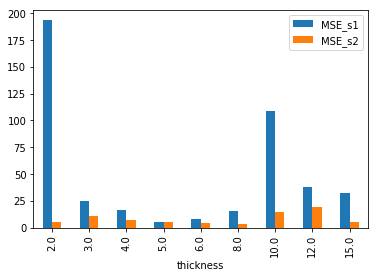

,MSE_s1,MSE_s2
thickness,,
2.0,193.365146,4.815931
3.0,24.851538,11.036820
4.0,16.224032,7.351969
5.0,5.220564,5.278305
6.0,8.358777,4.467468
8.0,15.327619,3.133522
10.0,108.925786,14.369749
12.0,37.731043,18.813039
15.0,32.336428,5.120994


In [154]:
# Is the error sourced by thickness ?
df = comparisonset[['MSE_s1', 'MSE_s2', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.show()
df

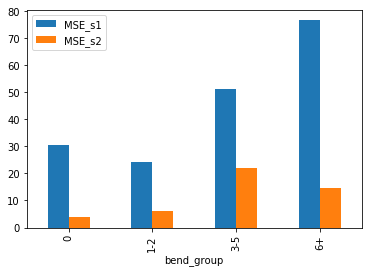

,MSE_s1,MSE_s2
bend_group,,
0,30.509992,4.024589
1-2,24.225035,6.097179
3-5,51.197260,22.104504
6+,76.594708,14.553955


In [155]:
# Is the error sourced by number of errors ?

df = comparisonset[['MSE_s1', 'MSE_s2', 'bend_group']].groupby('bend_group').mean()
df.plot.bar()
plt.show()
df

In [156]:
comparisonset.head()

,COART,pred_S1,pred_S2,target,MSE_s1,MSE_s2,cut_length,num_closed_patterns,num_open_patterns,total_area,...,thick_20.0,VAMAT,VALAJOUT,VALTOT,VOL_COST_CONVHULL,VOL_COST_RECTANGLE,VOL_COST_MPATTERN,bend_group,SURF_COST_RECTANGLE,APPROX_BEND_COST
0,L7011572,2.532661,0.525496,0.49,4.172465,0.001260,550.806946,2,0,14566.341797,...,0,0.49,0.95,1.44,0.000007,0.000007,0.000007,0,0.000033,0.950000
1,L8407220,6.810819,4.797794,6.10,0.505263,1.695741,4099.324707,14,0,177817.437500,...,0,6.10,4.52,10.62,0.000011,0.000011,0.000011,1-2,0.000034,1.506667
2,L8414000,8.841271,9.069647,12.86,16.150182,14.366778,1977.038452,4,0,48819.046875,...,0,12.86,2.46,15.32,0.000014,0.000011,0.000015,0,0.000131,2.460000
3,L6005092,8.561731,10.976526,10.01,2.097483,0.934173,3336.436768,18,0,135501.937500,...,0,10.01,5.98,15.99,0.000007,0.000007,0.000009,1-2,0.000057,1.993333
4,L3130840,8.266264,6.214531,5.87,5.742083,0.118702,1526.268555,6,0,27662.689453,...,0,5.87,2.39,8.26,0.000008,0.000007,0.000010,0,0.000098,2.390000


In [157]:
#mean_absolute_percentage_error
comparisonset['MAPE_error_s1'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_S1']), axis=1)
comparisonset['MAPE_error_s2'] = comparisonset.apply(lambda x: mean_absolute_percentage_error(x['target'], x['pred_S2']), axis=1)
comparisonset[[target, 'pred_S1', 'MAPE_error_s1', 'pred_S2', 'MAPE_error_s2']].head()

,VAMAT,pred_S1,MAPE_error_s1,pred_S2,MAPE_error_s2
0,0.49,2.532661,416.869658,0.525496,7.244163
1,6.10,6.810819,11.652767,4.797794,21.347641
2,12.86,8.841271,31.249836,9.069647,29.473976
3,10.01,8.561731,14.468223,10.976526,9.655605
4,5.87,8.266264,40.822221,6.214531,5.869356


In [158]:
mean_absolute_percentage_error(comparisonset['target'], comparisonset['pred_S2'])

33.41566907013853

In [159]:
comparisonset['MAPE_error_s2'].mean()

33.4156690701385

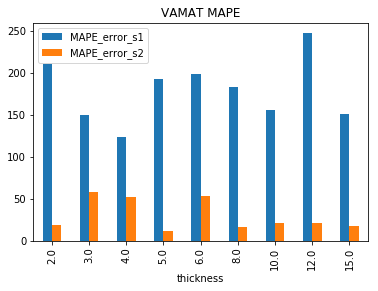

,MAPE_error_s1,MAPE_error_s2
thickness,,
2.0,210.702961,18.443647
3.0,149.831477,58.424756
4.0,123.447481,51.659340
5.0,192.311489,11.675571
6.0,199.377307,53.192810
8.0,183.199163,16.405340
10.0,156.037006,21.388847
12.0,247.207170,21.186972
15.0,151.496966,16.961469


In [160]:
df = comparisonset[['MAPE_error_s1', 'MAPE_error_s2', 'thickness']].groupby('thickness').mean()
df.plot.bar()
plt.title(f'{target} MAPE')
plt.show()
df

In [161]:
df = comparisonset[['MSE_s2', 'MAPE_error_s2', 'thickness', 'bend_group', 'COART']].groupby(['thickness', 'bend_group'])#.mean()
df.agg({'MSE_s2': ['mean', 'max'], 'MAPE_error_s2': ['mean', 'max'],'COART':['count'] })

MSE_s2             MAPE_error_s2             COART
                           mean         max          mean         max count
thickness bend_group                                                       
2.0       0            1.313112    3.915173     13.884945   30.856137     3
          1-2          1.280770    9.365195     24.632687   52.037025    12
          3-5          6.234078   56.800679     10.396093   33.901962    12
          6+          16.786809   31.103377     30.436403   39.807489     3
3.0       0            2.093294   23.049314     42.016479   73.132232    34
          1-2          2.705331   66.684176     57.628186  525.583435    56
          3-5         30.447559  322.553342     51.356152  379.741219    37
          6+          18.529096   63.070364    181.857272  845.452012     7
4.0       0            0.750929    9.525902     34.440580   68.510081    23
          1-2          3.425253   74.975602     50.969377  405.310033   116
          3-5         20.961972  283.543616     63.911587  606.060108    46
          6+           1.106291    1.941735     22.480633   49.766489     3
5.0       0            0.552277   14.001374     13.060737   33.200335    55
          1-2          1.915150  143.308843     10.100549   33.256337    79
          3-5         17.931765  216.278635     12.231764   29.234333    33
          6+          20.714974   80.990826     15.945314   22.079221     7
6.0       0            2.818562  155.373932     46.813974  102.729302   138
          1-2          3.737997  134.977204     59.729738  759.272577   179
          3-5         15.596517  267.064735     46.137922  256.121132    31
          6+           7.092217   15.271222     38.966985   55.724510     5
8.0       0            1.908024  101.851645     19.966549   56.422148   132
          1-2          2.026818   49.717421     13.186866   67.551536   130
          3-5         13.672737  273.032474     14.623342   64.874836    29
10.0      0            6.645578  248.937897     22.628960   75.230549    90
          1-2         15.413432  264.796156     20.285323   60.304187    95
          3-5         99.516260  669.851069     20.420938   31.062747     7
12.0      0           11.810877  284.773185     22.194977   99.074284    66
          1-2         31.446697  530.799827     19.338453   57.411147    38
          3-5          0.876711    0.876711     24.902357   24.902357     1
15.0      0            4.776751  109.551964     17.093937   53.161069    48
          1-2          5.295260   33.395575     15.228113   24.932819    11
          3-5         19.727751   19.727751     29.669962   29.669962     1

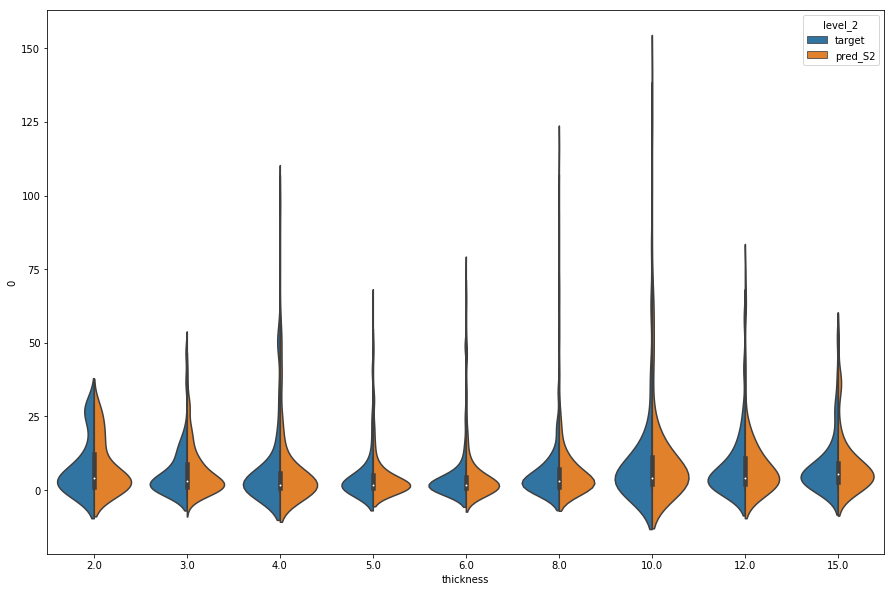

In [162]:
df=comparisonset[['target', 'pred_S2', 'COART', 'thickness']]
#df=df[df['thickness']!=15]
df.set_index(['COART', 'thickness'], inplace=True)
df = df.stack().reset_index()
fig, ax = plt.subplots(figsize=(15,10))
#ax.set_ylim(-20, 50)
sns.violinplot(x="thickness", y=0, data=df, split=True, hue='level_2', ax=ax)

plt.show()

/Users/cricket/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


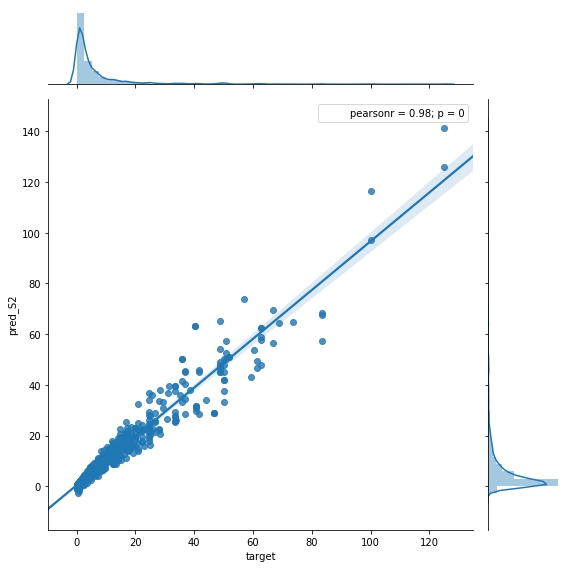

In [163]:
sns.jointplot(x='target', y='pred_S2', data=comparisonset, kind='reg', size=8)

In [164]:
df = comparisonset[['MSE_s2', 'COART', 'thickness']]
df.set_index('COART', inplace=True)
worst = df.groupby('thickness')['MSE_s2'].nlargest(3)
worst
#worst.to_csv('worst_s0.csv')

thickness  COART   
2.0        L6019231     56.800679
           L5606400     31.103377
           L5606430     16.956776
3.0        L8416761    322.553342
           L8416631    322.553342
           L8416751    322.553342
4.0        L8055510    283.543616
           L8055540    158.101881
           L8835250     93.256896
5.0        L8834210    216.278635
           L8415690    143.308843
           L7072760    122.991588
6.0        L3121180    267.064735
           L7033761    155.373932
           L7057910    134.977204
8.0        L2609180    273.032474
           L3045400    101.851645
           L8024980     59.723229
10.0       L7073230    669.851069
           L7065260    264.796156
           L3125470    248.937897
12.0       L3020620    530.799827
           L3020500    530.799827
           L3054490    284.773185
15.0       L8833300    109.551964
           L2512080     34.481813
           L8835240     33.395575
Name: MSE_s2, dtype: float64